# Doppler shifts via Fourier Transforms

In [2]:
import sympy
from sympy import *
print("Using sympy version", sympy.__version__)
init_session(quiet=True)
beta, x, k = symbols(r'\beta_\mathrm{eq} x k')

Using sympy version 1.3



In order to apply the Doppler shift and integrate over the visible disk of the star, we need to compute the integral

$$
\begin{align}
    \hat{J}(k)
    &=
    \int_{-1}^{1}
        \int_{-\sqrt{1 - x^2}}^{\sqrt{1 - x^2}}
        % MAGIC
        \left( 
            1 - \beta_\mathrm{eq} x 
        \right) ^ {2\pi i k}
        % MAGIC
        \mathrm{d}y
        \,
        \mathrm{d}x
      \\ 
      &=
      \int_{-1}^{1}
          2(1 - \beta_\mathrm{eq} x)^{2\pi i k}\sqrt{1 - x^2}
      \mathrm{d}x
\end{align}
$$

Let's try it with ``sympy``:

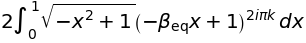

In [3]:
gamma = 2 * pi * k * I
f = 2 * (1 - beta * x) ** gamma * sqrt(1 - x ** 2)
integrate(f, (x, 0, 1))

Unfortunately, it looks like ``sympy`` can't do this integral, but [Wolfram can](https://www.wolframalpha.com/input/?i=integrate+2+*+(1+-+beta+x)%5E%7B2+*+pi+*+k+*+i%7D+*+sqrt(1+-+x%5E2)+from+x+%3D+-1+to+x+%3D+1):

$$
\begin{align}
    \hat{J}(k)
    &=
    \pi \, _{2}F_{1}
        \left(
            -\pi i k, \, 
            \frac{1}{2} - \pi i k; \,
            2; \,
            \beta_\mathrm{eq}^2
        \right)
\end{align}
$$

## Let's implement this:

In [12]:
%matplotlib inline

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import mpmath

In [14]:
def _hyp2f1(a, b, c, z):
    """
    The Hypergeometric function 2F1 for 
    complex-valued arguments.
    
    """
    res = mpmath.hyp2f1(a, b, c, z)
    return float(res.real) + float(res.imag) * 1j

# Vectorize it
hyp2f1 = np.vectorize(_hyp2f1)

In [15]:
def I_num(xi, I0, alpha=0):
    """
    Return the shifted spectrum, computed numerically.
    
    """
    xi0 = xi + alpha
    return np.interp(xi0, xi, I0)

In [16]:
def S_num(xi, I0, alpha=0, npts=1000):
    """
    Return the disk-integrated spectrum, computed numerically.
    
    """
    S = np.zeros_like(xi)
    A = 0
    beta = np.exp(alpha) - 1
    for x in np.linspace(-1, 1, npts + 2)[1:-1]:
        beta_x = beta * x
        alpha_x = np.log(1 + beta_x)
        S += I_num(xi, I0, alpha=alpha_x) * np.sqrt(1 - x ** 2)
        A += np.sqrt(1 - x ** 2)
    return np.pi * S / A

In [17]:
def I(xi, I0, alpha=0):
    """
    Return the shifted spectrum, computed via an FFT.
    
    """
    # Number of wavelength bins
    N = len(xi)
    
    # Take the FFT
    fI0 = np.fft.rfft(I0)
    k = np.fft.rfftfreq(N, xi[1] - xi[0])
    
    # Apply the translation
    fI0 *= np.exp(2 * np.pi * alpha * 1j * k)
    
    # Take the inverse FFT and return
    return np.fft.irfft(fI0, N)

In [18]:
def S(xi, I0, alpha=0, npts=1000):
    """
    Return the disk-integrated spectrum, computed via an FFT.
    
    """
    # Number of wavelength bins
    N = len(xi)
    
    # Take the FFT
    fI0 = np.fft.rfft(I0)
    k = np.fft.rfftfreq(N, xi[1] - xi[0])
    
    # Apply the integral of the translation    
    fI0 *= np.pi * hyp2f1(-k * np.pi * 1j, 0.5 - k * np.pi * 1j, 2, beta ** 2)
    
    # Take the inverse FFT and return
    return np.fft.irfft(fI0, N)

## Plot the shifted spectrum

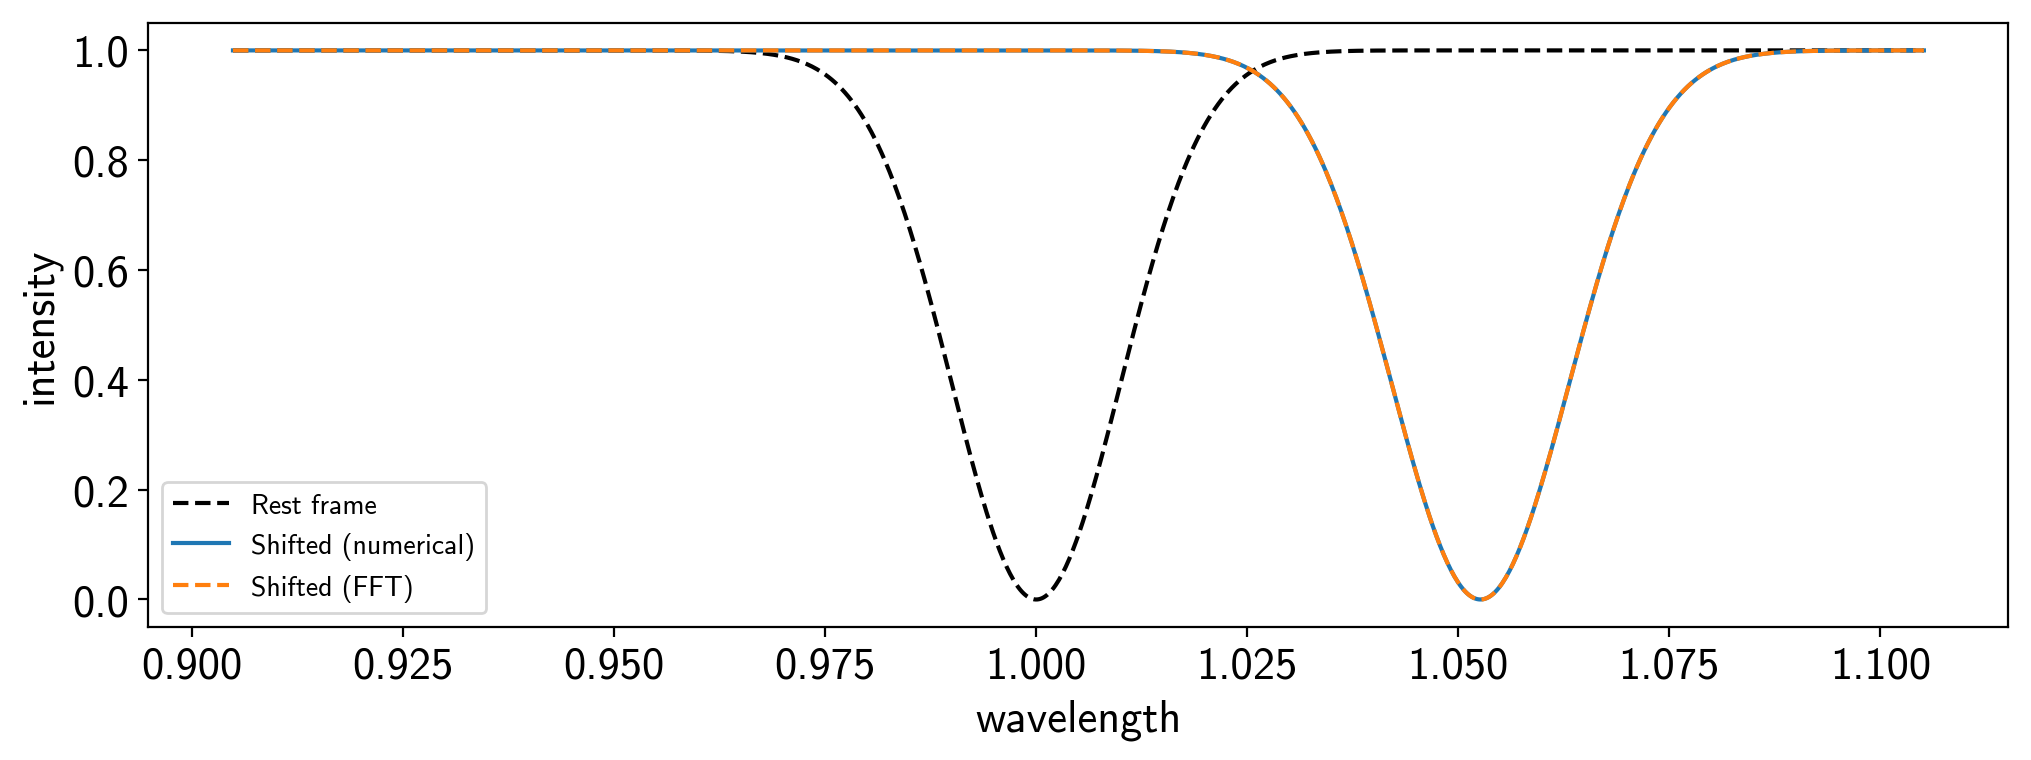

In [19]:
# An evenly sampled timeseries in xi = log(wavelength)
xi = np.linspace(-0.1, 0.1, 1000)
lam = np.exp(xi)

# A gaussian absorption line
amp = 1.0
mu = 1.0
sigma = 0.01
I0 = 1 - amp * np.exp(-0.5 * (lam - mu) ** 2 / sigma ** 2)

# A moderate doppler shift
beta = 0.05
alpha = np.log(1 - beta)

# Plot the shifted line
plt.plot(lam, I0, 'k--', label="Rest frame")
plt.plot(lam, I_num(xi, I0, alpha=alpha), 'C0', label="Shifted (numerical)")
plt.plot(lam, I(xi, I0, alpha=alpha), 'C1--', label="Shifted (FFT)")
plt.legend(fontsize=10)
plt.xlabel("wavelength")
plt.ylabel("intensity");

## Plot the disk-integrated spectrum

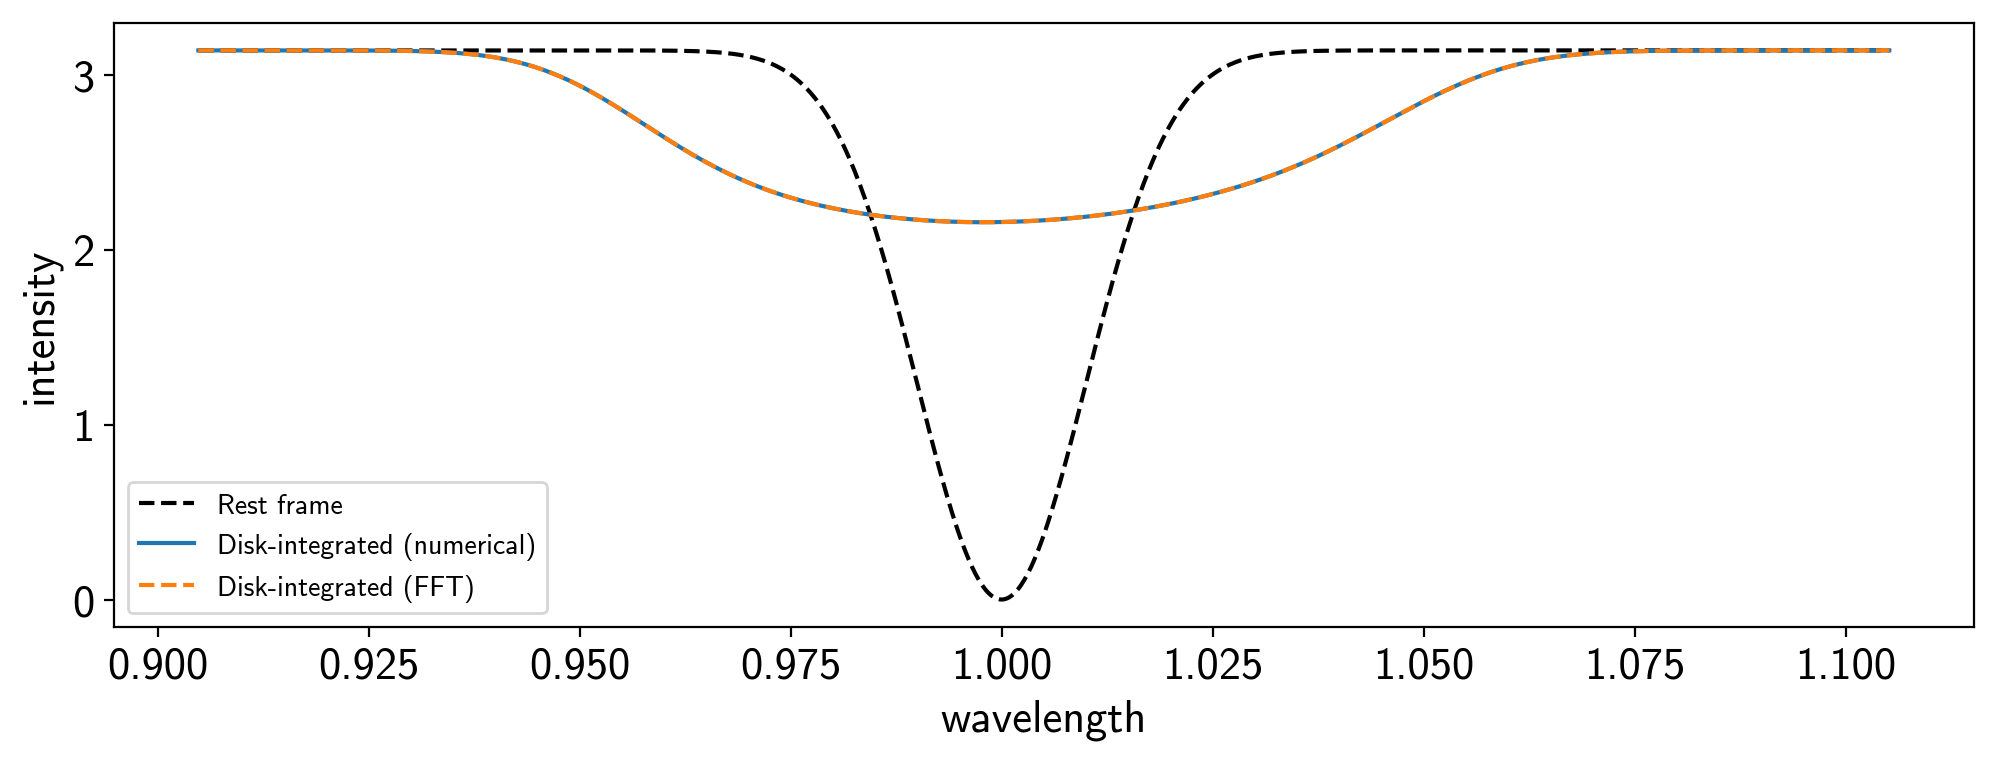

In [20]:
plt.plot(lam, S_num(xi, I0, alpha=0), 'k--', label="Rest frame");
plt.plot(lam, S_num(xi, I0, alpha=alpha), 'C0', label="Disk-integrated (numerical)");
plt.plot(lam, S(xi, I0, alpha=alpha), 'C1--', label="Disk-integrated (FFT)");
plt.legend(fontsize=10)
plt.xlabel("wavelength")
plt.ylabel("intensity");